In [ ]:
# TM10007 Machine learning assignmnet, ECG dataset
# Version 1.0
#
# The following notebook contains the code that walks through the various steps
# of preprocessing, feature selection, hyperparameter tuning and validation of 
# a random forest and a support vector machine classifier on the provided ECG
# dataset.
#
# By group 7:
# Cile van Holthe,     C.C.vanHolthe@student.tudelft.nl 
# Jop Schneijdenberg,  J.W.Schneijdenberg@student.tudelft.nl 
# Arya Baban,          A.Baban@student.tudelft.nl 
# Jordan Verburg,      J.W.Verburg@student.tudelft.nl 


# Module imports

In [17]:
# import of all the required modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import zipfile

from sklearn import svm
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# File import and dataframe creation

In [5]:
# import the TM10007 machinelearning github repository and unpack the ECG data 
# zipfile
!git clone https://github.com/jveenland/tm10007_ml.git
with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

# create a panda's dataframe from the ECG .csv file extracted form the zipfile
df = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 38 (delta 11), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [ ]:
plt.style.use('ggplot') # make plots look better


# Basic feature and label extraction and preparation

In [6]:
# set up IDs and targets (features and labels) 
X = df.drop(['label'], axis=1) # features = columns other than label column
y = df['label'] # label is the label column

# create train and test set, with a 3:7 ratio, stratification on the target/label
# to ensure both test and train set are compareable in target/label count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    stratify=y, random_state=0) 

# Preprocessing

Identfying and dropping features deemed less important by sorting on least contributing frequencies on a per lead basis. 

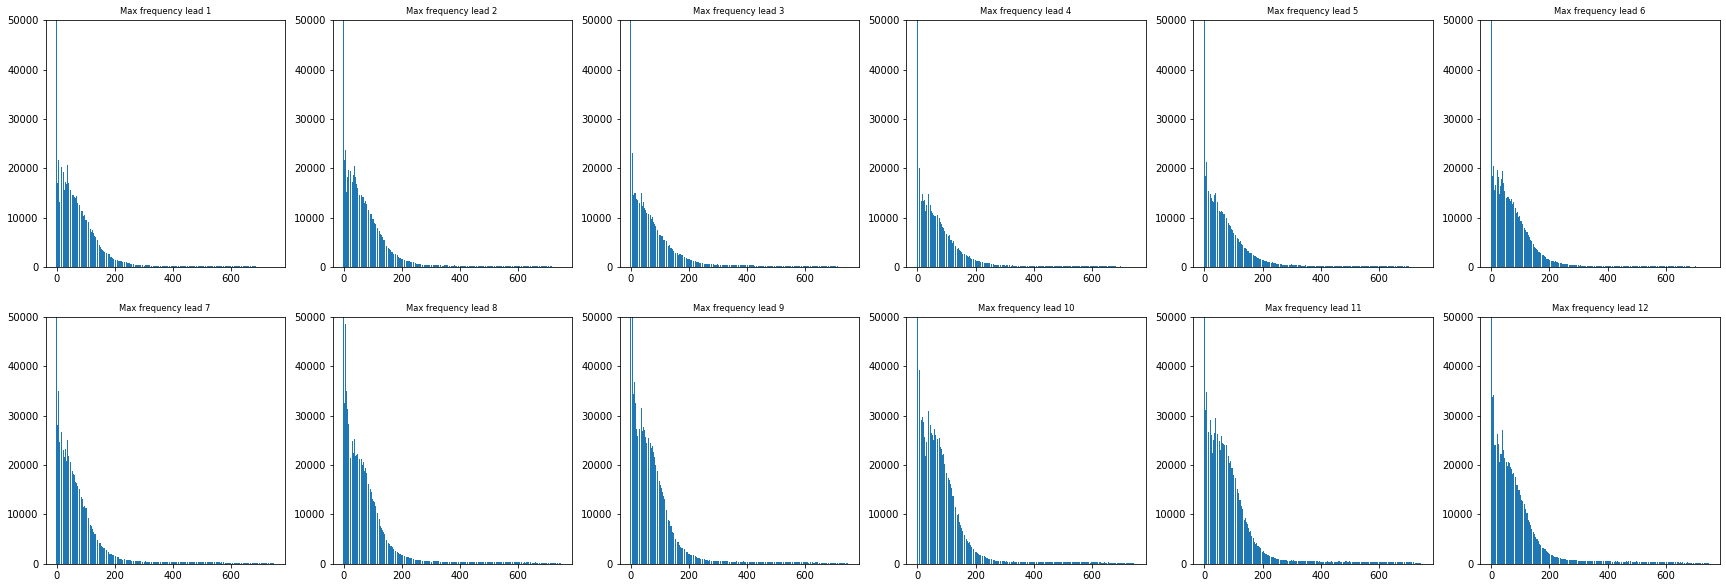

In [10]:
# checking the contributions of each frequency interval per lead
sums = X_train.sum(axis=0)

# plotting the max value per ecg lead to check if they have an amplitude above frequency bin 250
fig = plt.figure(figsize=(30,10))

for lead in range(0,12):
    ax = fig.add_subplot(2, 6, 1+lead)
    ax.set_title(f"Max frequency lead {lead+1}", fontsize='small')
    ax.set_ylim([0, 50000])
    plt.bar(range(749), sums[(0+lead*750):(749+lead*750)])

X_train_dropped = X_train.copy()
X_test_dropped = X_test.copy()

for drop in range(0,12):
    X_train_dropped.drop(X_train_dropped.iloc[:,(250+(drop*250)):(750+(drop*250))], inplace=True, axis=1)
    X_test_dropped.drop(X_test_dropped.iloc[:,(250+(drop*250)):(750+(drop*250))], inplace=True, axis=1)

Feature selection based on the selectKbest method using "mutual info". Performed seperately twice, once to prepare features for a random forest classifier, a second time to prepare features for a SVM classifier.

In [13]:
# prepare the RFC and SVM feature selection sets by copying the sets previously 
# prepared form which the features deemed least important were dropped
X_train_select_rf = X_train_dropped.copy()
X_test_select_rf = X_test_dropped.copy()

X_train_select_SVM = X_train_dropped.copy()
X_test_select_SVM = X_test_dropped.copy()

In [14]:
# for SVM the data is also scaled (not important for RFC)
scaler = preprocessing.MinMaxScaler()
X_train_scaled_SVM = scaler.fit_transform(X_train_select_SVM[X_train_select_SVM.columns])
X_test_scaled_SVM = scaler.transform(X_test_select_SVM)

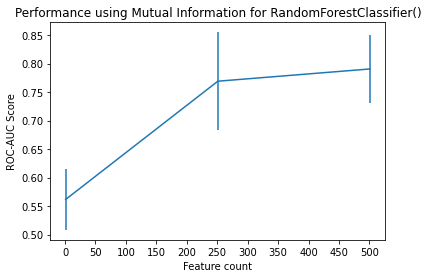

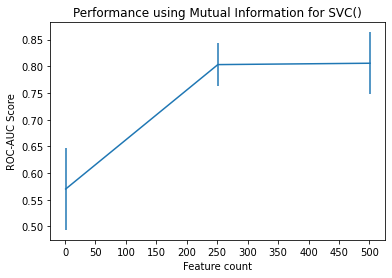

In [49]:
# run a basic RFC and SVM classifier with increasing K values for the mutual 
# info method maintaining a list of scores (and standard deviations) to 
# determine the best number of features to keep. 
# For demonstration purposes the range of 'k_values' is set to a conservative 
# range of two values as the process is computationally expensive. For the 
# assignment a range up to 500 in increments of 10 was explored rather than 
# increments of 250.
classifiers = (RandomForestClassifier(), SVC())
trainsets = (X_train_select_rf, X_train_select_SVM)

for classifier, trainset in zip(classifiers, trainsets):
  clf = make_pipeline(SelectKBest(mutual_info_classif, k=1), classifier)

  score_means = list()
  score_stds = list()
  k_values = range(1,502,250)

  for k_value in k_values:
    clf.set_params(selectkbest__k=k_value)
    this_scores = cross_val_score(clf, trainset, y_train, scoring='roc_auc')
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

  plt.errorbar(k_values, score_means, np.array(score_stds))
  plt.title(f"Performance using Mutual Information for {classifier}")
  plt.xticks(np.linspace(0, 500, 11))
  plt.xlabel("Feature count")
  plt.ylabel("ROC-AUC Score")
  plt.show()

# Hyperparameter tuning using random grid search



RFC

In [21]:
# fit kbest feature selector and transform train and test data 
# (k=160 was determined as best for RFC)
kbest = SelectKBest(mutual_info_classif, k=160)
X_train_kbrf = kbest.fit_transform(X_train_select_rf, y_train)
X_test_kbrf = kbest.transform(X_test_select_rf)

# create parameter ranges 
n_estimators = range(100,801, 10)
max_features = ['sqrt', 0.2, None]
min_samples_split = range(2, 9, 1)
min_samples_leaf = range(1, 9, 1)
bootstrap = [True, False]

# grid creation using the parameter ranges 
rfc_grid = {'n_estimators': n_estimators,
            'max_features': max_features,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

rfc_gridsearch = RandomizedSearchCV(RandomForestClassifier(), rfc_grid, scoring = 'roc_auc', cv=5, n_iter=50, n_jobs=-1, verbose=2)

rfc_gridsearch.fit(X_train_kbrf, y_train)

# show the best parameters found
print(rfc_gridsearch.best_params_)

print(rfc_gridsearch.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'bootstrap': False,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 280}

SVM

In [25]:
# fit kbest feature selector and transform train and test data 
# (k=260 was determined as best for SVM)
kbest = SelectKBest(mutual_info_classif, k=260)
X_train_kbsvm = kbest.fit_transform(X_train_scaled_SVM, y_train)
X_test_kbsvm = kbest.transform(X_test_scaled_SVM)

# create random parameters 
c_params = [2**a for a in range(-5,16,2)]
gammas = [2**a for a in range(-15,4,2)]
kernels = ['rbf', 'poly', 'sigmoid']

# grid creation 
svm_grid = {'C': c_params,
            'gamma': gammas,
            'kernel': kernels}

# Random search of parameters, using 5 fold cv, search 20 random combinations 
svm_gridsearch = RandomizedSearchCV(SVC(), svm_grid, scoring = 'roc_auc', n_iter=50, cv=5, n_jobs=-1, verbose=2)

svm_gridsearch.fit(X_train_kbsvm, y_train)

# show the best parameters found
print(svm_gridsearch.best_params_)

print(svm_gridsearch.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'kernel': 'rbf', 'gamma': 0.5, 'C': 0.5}
0.8163873746867167


# Scoring and validation

RFC

In [34]:
# create cross validation scores with chosen hyperparameters and the train set
clf = rfc_gridsearch.best_estimator_
scoresRFC = cross_val_score(clf, X_train_kbrf, y_train, cv=5, scoring='roc_auc')
scoresRFC

array([0.865625  , 0.89273183, 0.7443609 , 0.90157895, 0.78157895])

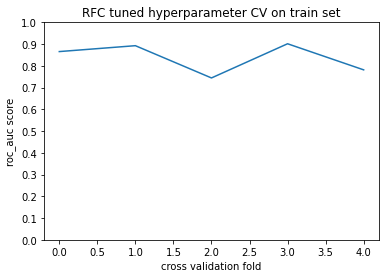

In [35]:
plt.plot(scoresRFC)
plt.title("RFC tuned hyperparameter CV on train set")
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("cross validation fold")
plt.ylabel("roc_auc score")
plt.show()

In [36]:
clf.fit(X_train_kbrf, y_train)
print(clf.score(X_test_kbrf, y_test))

0.8433734939759037


SVM

In [37]:
# create cross validation scores with chosen hyperparameters and the train set
clf = svm_gridsearch.best_estimator_
scoresSVM = cross_val_score(clf, X_train_kbsvm, y_train, cv=5, scoring='roc_auc')
scoresSVM

array([0.85885417, 0.81654135, 0.7112782 , 0.88052632, 0.81473684])

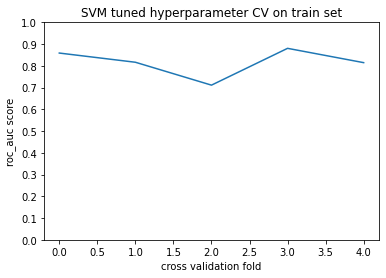

In [38]:
plt.plot(scoresSVM)
plt.title("SVM tuned hyperparameter CV on train set")
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("cross validation fold")
plt.ylabel("roc_auc score")
plt.show()

In [39]:
clf.fit(X_train_kbsvm, y_train)
print(clf.score(X_test_kbsvm, y_test))

0.8473895582329317


# Learning curves

RFC and SVM

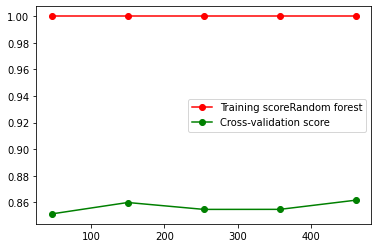

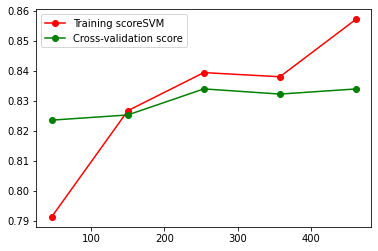

In [42]:
tunedclassifiers = (rfc_gridsearch.best_estimator_, svm_gridsearch.best_estimator_)
trainsets = (X_train_kbrf, X_train_kbsvm)
names = ("Random forest", "SVM")

for classifier, trainset, name in zip(tunedclassifiers, trainsets, names):
  train_sizes, train_scores, valid_scores = learning_curve(
  classifier, trainset, y_train, cv=5)

  train_scores_mean = np.mean(train_scores, axis=1)
  valid_scores_mean = np.mean(valid_scores, axis=1)

  # Plot learning curve
  plt.plot(
      train_sizes, train_scores_mean, "o-", color="r", label=f"Training score{name}"
      )
  plt.plot(
      train_sizes, valid_scores_mean, "o-", color="g", label="Cross-validation score"
  )
  plt.legend(loc="best")

  plt.show()

# Extra: Correlation matrix
Explored, but ultimately not used as the dimensionality reduction and feature quality were deemed insufficient.

In [43]:
# find correlations in the feature train set, highly correlated features could 
# be excluded to reduce overfitting and reduce dimensionality
correlation_matrix = X_train_dropped.corr().abs()

In [45]:
# display a heatmap of the correlation matrix, a triangular boolean mask is
# created and applied first as the correlation matrix is mirrored on the 
# diagonal(the diagonal is masked out as well, as this simply shows the 
# correlation of the features with themselves, i.e. 1.0)

diag_mask = np.array(np.triu(np.ones(correlation_matrix.shape), k=1),
                     dtype=bool)
masked_matrix = correlation_matrix.where(diag_mask)

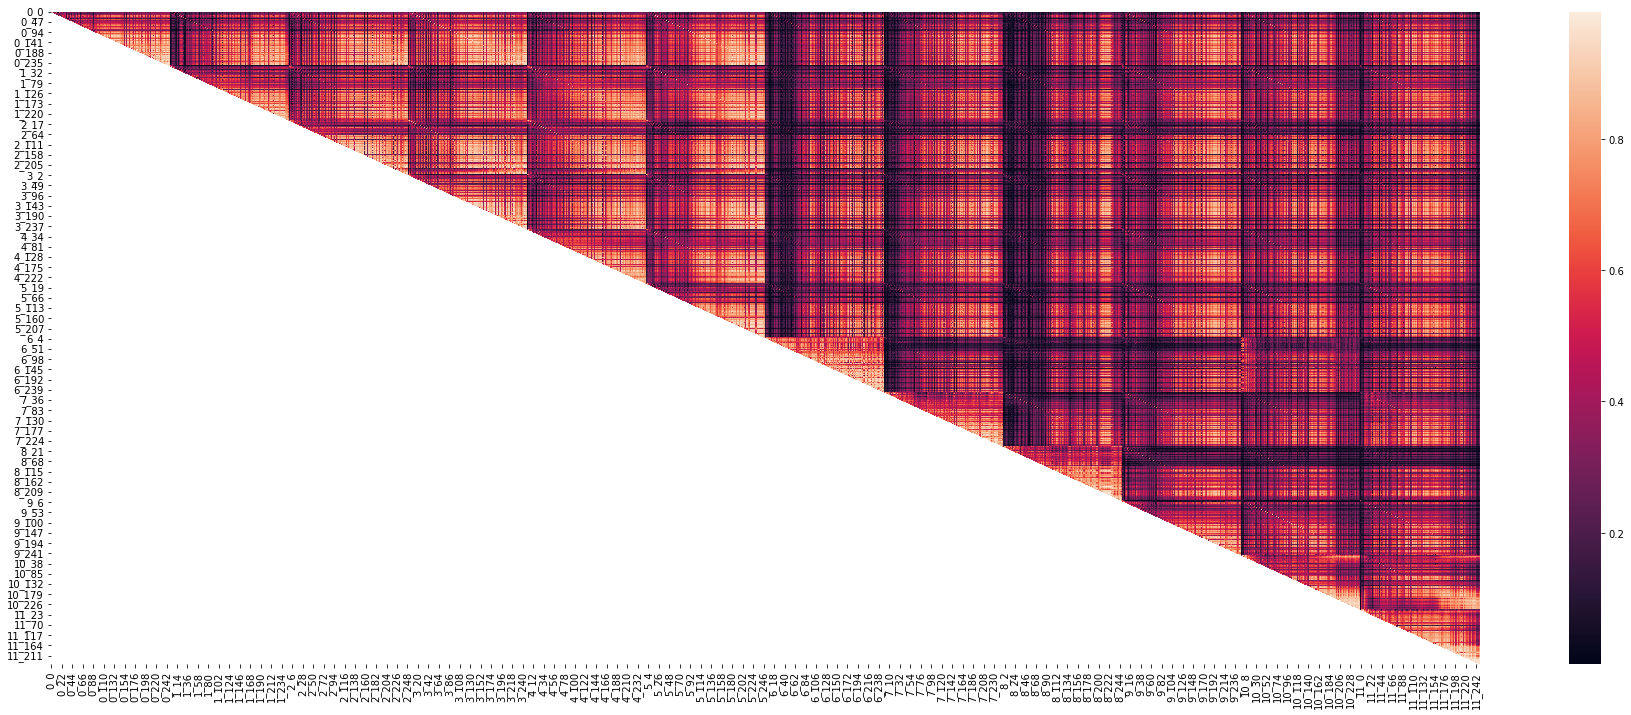

In [47]:
# plot a heatmap of the correlations
import seaborn
plt.figure(figsize=(32, 12))
seaborn.heatmap(masked_matrix)
plt.show;

In [46]:
# give a count of features with high (above 0.7) correlation with at least one 
# other features (additionally saves the columns of these features)
correlation_list = [column for column in masked_matrix.columns if any(masked_matrix[column] > 0.7)]
print('Columns with at least one instance of correlation exceeding 0.7: ' ,
      (len(correlation_list)))

Columns with at least one instance of correlation exceeding 0.7:  2673
